In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Optional: to make plots look nicer
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') # To ignore warnings

In [2]:
# Adjust the path if your notebook is elsewhere relative to the data folder
df = pd.read_csv('../data/Mall_Customers.csv')

In [3]:
print("First 5 rows:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nStatistical Summary:")
print(df.describe())
print("\nCheck for Null Values:")
print(df.isnull().sum())

First 5 rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Statistical Summary:
     

In [4]:
# We'll use 'Annual Income (k$)' and 'Spending Score (1-100)' for segmentation
# Let's rename them for easier use
df.rename(columns={'Annual Income (k$)': 'Annual_Income',
                   'Spending Score (1-100)': 'Spending_Score'}, inplace=True)

X = df[['Annual_Income', 'Spending_Score']]
print("\nSelected features for clustering (X):")
print(X.head())


Selected features for clustering (X):
   Annual_Income  Spending_Score
0             15              39
1             15              81
2             16               6
3             16              77
4             17              40


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# X_scaled is a NumPy array, let's see its first few rows
print("\nScaled features (X_scaled):")
print(X_scaled[:5])


Scaled features (X_scaled):
[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]


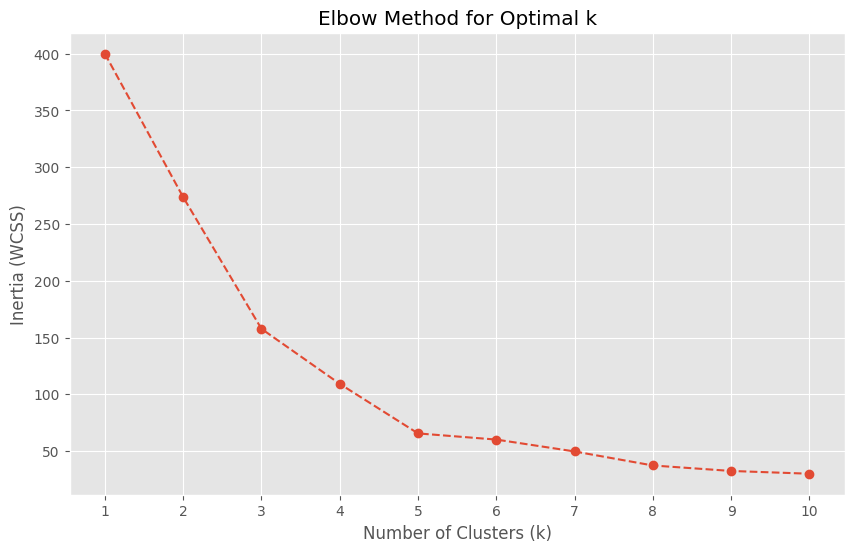

In [6]:
inertia = [] # WCSS (Within-Cluster Sum of Squares)
k_range = range(1, 11) # Test k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto') # n_init='auto' suppresses a warning
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Interpretation of Elbow Method
Looking at the plot above, the "elbow" point appears to be at **k=5**. After k=5, the decrease in inertia (WCSS) becomes less significant. Therefore, we will choose 5 as the optimal number of clusters.

In [8]:
optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')
df['Cluster'] = kmeans_final.fit_predict(X_scaled) # Assign cluster labels to the original dataframe

print("\nDataFrame with Cluster Labels:")
print(df.head())

print("\nCluster Centers (in scaled space):")
print(kmeans_final.cluster_centers_)


DataFrame with Cluster Labels:
   CustomerID  Gender  Age  Annual_Income  Spending_Score  Cluster
0           1    Male   19             15              39        4
1           2    Male   21             15              81        2
2           3  Female   20             16               6        4
3           4  Female   23             16              77        2
4           5  Female   31             17              40        4

Cluster Centers (in scaled space):
[[-0.20091257 -0.02645617]
 [ 0.99158305  1.23950275]
 [-1.32954532  1.13217788]
 [ 1.05500302 -1.28443907]
 [-1.30751869 -1.13696536]]


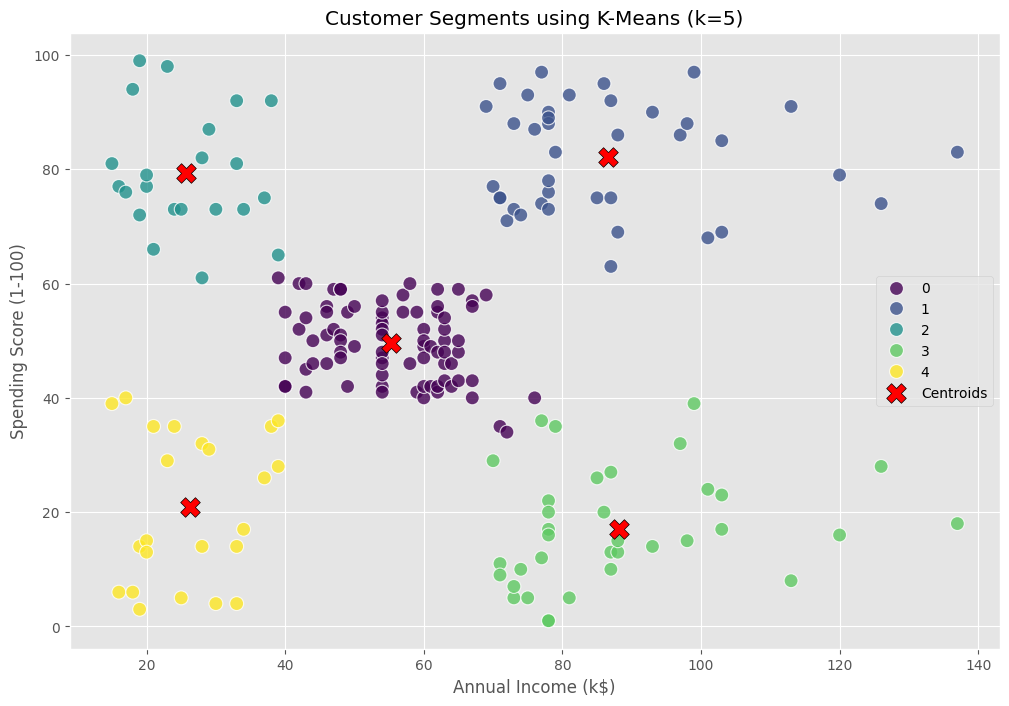

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual_Income', y='Spending_Score', hue='Cluster', palette='viridis', s=100, alpha=0.8, legend='full')

# Plotting the centroids (need to inverse_transform them from scaled space to original space for plotting on original axes)
centroids_original_space = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_original_space[:, 0], centroids_original_space[:, 1],
            marker='X', s=200, c='red', label='Centroids', edgecolor='black')

plt.title(f'Customer Segments using K-Means (k={optimal_k})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.show()

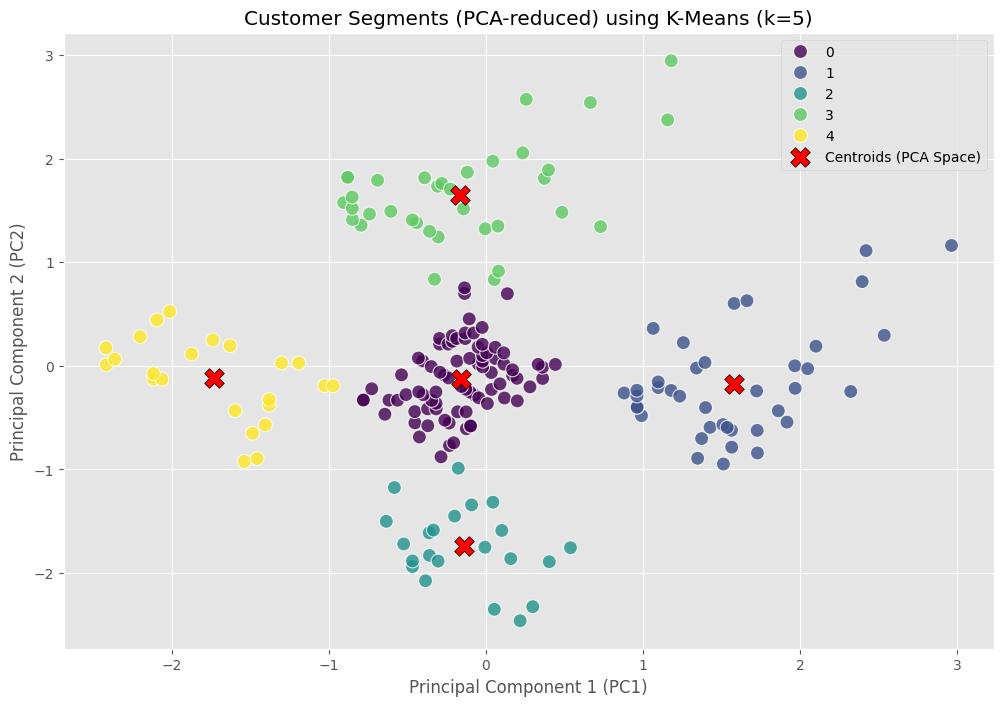


Explained Variance Ratio by PCA components: [0.50495142 0.49504858]


In [10]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled) # X_scaled are the features used for K-Means

# Create a DataFrame for PCA results for easier plotting with seaborn
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster'] # Add the cluster labels from K-Means

# Plot the PCA-reduced clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.8, legend='full')

# Plotting the centroids in PCA space
# The K-Means cluster centers are in the original scaled feature space (X_scaled)
# We need to transform these centers using the same PCA model
centroids_pca_space = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca_space[:, 0], centroids_pca_space[:, 1],
            marker='X', s=200, c='red', label='Centroids (PCA Space)', edgecolor='black')

plt.title(f'Customer Segments (PCA-reduced) using K-Means (k={optimal_k})')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.grid(True)
plt.show()

print("\nExplained Variance Ratio by PCA components:", pca.explained_variance_ratio_)

### Interpretation of Clusters

Based on the scatter plot of Annual Income vs. Spending Score (and the PCA plot), we can describe the 5 clusters:

*   **Cluster 0 (e.g., Careful/Standard):** These customers might have moderate annual income and moderate spending scores.
*   **Cluster 1 (e.g., Target/High Value):** These customers have high annual income and high spending scores. They are prime targets for marketing.
*   **Cluster 2 (e.g., Low Income, High Spending/Risky or Young):** These customers have low annual income but high spending scores. They might be younger, or potentially spending beyond their means.
*   **Cluster 3 (e.g., Savers/Low Value):** These customers have low annual income and low spending scores.
*   **Cluster 4 (e.g., High Income, Low Spending/Careful Rich):** These customers have high annual income but low spending scores. They are careful with their money.

*(Adjust the descriptions based on how your clusters actually look. You can inspect `df.groupby('Cluster').mean()` to get average income/spending for each cluster to help with this.)*

In [12]:
print("\nAverage values per cluster (original features):")
cluster_characteristics = df.groupby('Cluster')[['Annual_Income', 'Spending_Score', 'Age']].mean() # Added Age for more insight
print(cluster_characteristics)


Average values per cluster (original features):
         Annual_Income  Spending_Score        Age
Cluster                                          
0            55.296296       49.518519  42.716049
1            86.538462       82.128205  32.692308
2            25.727273       79.363636  25.272727
3            88.200000       17.114286  41.114286
4            26.304348       20.913043  45.217391
